# 项目准备

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
pd.set_option("max_columns", 200)

In [72]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, "data")
SCRIPT_PATH = os.path.join(ROOT_PATH, "script")
MODEL_PATH = os.path.join(ROOT_PATH, "model")
TEST1_PATH = os.path.join(ROOT_PATH, "data/test1/")

## 读取数据

In [3]:
dfs = list()
for file in glob(os.path.join(DATA_PATH, "train", "*")):
    if len(file) > 4 and file[-4:] == ".csv":
        dfs.append(pd.read_csv(file))
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

### 修改column name

In [4]:
df.columns = ["Timestamp", "grid"] + [110-10*i for i in range(12)] + ["label"]
df.Timestamp = pd.to_datetime(df.Timestamp, format="%Y-%m-%d %H:%M:%S")

In [5]:
df.head()

,Timestamp,grid,110,100,90,80,70,60,50,40,30,20,10,0,label
0,2018-08-15 02:00:00,OL13F1i5014j2513,16 1 3 3,17 0 2 2,15 0 2 2,1 0 4 4,3 0 1 1,5 0 0 0,6 0 0 0,6 0 1 1,3 1 4 4,1 0 1 1,3 0 2 2,1 0 0 0,4 1 2 0 2 1
1,2018-08-15 02:00:00,OL13F1i5055j2490,20 0 0 0,24 1 1 1,11 0 1 1,0 0 2 2,1 0 0 0,0 0 0 0,6 1 2 2,2 0 1 0,0 0 0 1,0 0 0 0,0 0 0 0,0 0 0 0,2 2 1 0 0 0
2,2018-08-15 02:00:00,OL13F1i5037j2536,1 0 0 0,0 0 0 0,4 0 0 0,1 0 1 1,2 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,1 0 0 0,0 0 0 0 0 0
3,2018-08-15 02:00:00,OL13F1i5070j2494,1 0 1 1,2 0 0 0,0 0 0 0,2 0 0 0,4 0 0 0,12 0 0 0,10 0 1 1,2 0 1 1,0 0 0 0,0 0 1 1,2 0 0 0,2 0 0 0,1 1 0 0 0 0
4,2018-08-15 02:00:00,OL13F1i5072j2499,16 0 1 1,8 0 1 1,6 0 0 0,8 1 2 2,0 0 0 0,5 0 0 0,2 0 0 0,4 0 0 0,1 0 0 0,1 0 1 1,5 0 1 1,0 0 0 0,1 0 0 1 0 0


## 数据增强 + 转换数据
这里根据之前的先验correlation matrix可以看到label和最近一个小时的发单量强相关，一小时前的数据不是很重要。\
为了增强数据，我们将使用过去7个时间片做数据增强。

In [6]:
TIMEPIECE = 7


#################################
###   Generate Dict for using
#################################
prefix = ["idle_drive", "unboard_order", "order_create", "respond_order"]

dic = dict((pre+str(i),[]) for pre in prefix for i in range(TIMEPIECE, 0, -1))

temp_dic = {"grid":[], "Timestamp":[], "label":[]}
dic.update(temp_dic)


#################################
###   Read csv into Dict
#################################

def write_into_dic(row):
    for i in range(2, 15-TIMEPIECE):
        dic["grid"].append(row["grid"])
        dic["Timestamp"].append(row["Timestamp"]-pd.Timedelta(df.columns[i], unit="m"))
        label_col = df.columns[i+TIMEPIECE]
        if label_col == "label":
            dic["label"].append(row[label_col].split(" ")[0])
        else:
            dic["label"].append(row[label_col].split(" ")[2])
            
        for j, col in enumerate(df.columns[i:i+TIMEPIECE]):
            values = row[col].split(" ")
            dic["idle_drive"+str(TIMEPIECE-j)].append(values[0])
            dic["unboard_order"+str(TIMEPIECE-j)].append(values[1])
            dic["order_create"+str(TIMEPIECE-j)].append(values[2])
            dic["respond_order"+str(TIMEPIECE-j)].append(values[3])

for i in range(len(df)):
    row = df.loc[i]
    write_into_dic(row)
    
t = pd.DataFrame.from_dict(dic)
t = t.reindex(sorted(t.columns), axis=1)
t

,Timestamp,grid,idle_drive1,idle_drive2,idle_drive3,idle_drive4,idle_drive5,idle_drive6,idle_drive7,label,order_create1,order_create2,order_create3,order_create4,order_create5,order_create6,order_create7,respond_order1,respond_order2,respond_order3,respond_order4,respond_order5,respond_order6,respond_order7,unboard_order1,unboard_order2,unboard_order3,unboard_order4,unboard_order5,unboard_order6,unboard_order7
0,2018-08-15 00:10:00,OL13F1i5014j2513,6,5,3,1,15,17,16,1,0,0,1,4,2,2,3,0,0,1,4,2,2,3,0,0,0,0,0,0,1
1,2018-08-15 00:20:00,OL13F1i5014j2513,6,6,5,3,1,15,17,4,1,0,0,1,4,2,2,1,0,0,1,4,2,2,0,0,0,0,0,0,0
2,2018-08-15 00:30:00,OL13F1i5014j2513,3,6,6,5,3,1,15,1,4,1,0,0,1,4,2,4,1,0,0,1,4,2,1,0,0,0,0,0,0
3,2018-08-15 00:40:00,OL13F1i5014j2513,1,3,6,6,5,3,1,2,1,4,1,0,0,1,4,1,4,1,0,0,1,4,0,1,0,0,0,0,0
4,2018-08-15 00:50:00,OL13F1i5014j2513,3,1,3,6,6,5,3,0,2,1,4,1,0,0,1,2,1,4,1,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728995,2018-08-09 20:20:00,OL13F1i5033j2519,726,646,711,754,818,880,924,55,37,55,37,43,53,49,36,34,45,37,34,46,45,32,20,32,20,22,20,12,18
728996,2018-08-09 20:30:00,OL13F1i5033j2519,605,726,646,711,754,818,880,48,55,37,55,37,43,53,49,51,34,45,37,34,46,45,22,20,32,20,22,20,12
728997,2018-08-09 20:40:00,OL13F1i5033j2519,445,605,726,646,711,754,818,37,48,55,37,55,37,43,53,40,51,34,45,37,34,46,29,22,20,32,20,22,20
728998,2018-08-09 20:50:00,OL13F1i5033j2519,465,445,605,726,646,711,754,39,37,48,55,37,55,37,43,37,40,51,34,45,37,34,17,29,22,20,32,20,22


### 保存结果，方便下次使用

In [7]:
t.to_csv(os.path.join(DATA_PATH, "splited_training_set.csv"))

## Pin一下, 下次开始的起点读取数据。

In [5]:
t = pd.read_csv(os.path.join(DATA_PATH, "splited_training_set.csv"), index_col=0)
# 再转一下数据到date_time
t.Timestamp = pd.to_datetime(t.Timestamp, format="%Y-%m-%d %H:%M:%S")

## Grid编码

In [6]:
# check 之前的编码文件是否存在
def grid_encoding(df):
    if os.path.isfile(os.path.join(DATA_PATH, "grid_encoding.pkl")):
        with open(os.path.join(DATA_PATH, "grid_encoding.pkl"), 'rb') as f:
            grid_encoding = pickle.load(f)
        df.grid = df.grid.map(lambda x: grid_encoding[x])

    # 如果不在的话生成一个pickle编码字典
    else:
        grid_encoding = dict(zip(df.grid, df.grid.astype('category').cat.codes))
        df["grid"] = df.grid.astype('category').cat.codes
        with open(os.path.join(DATA_PATH, "grid_encoding.pkl"), "wb") as f:
            pickle.dump(grid_encoding, f)
    
    return df
            
t = grid_encoding(t)

## 新增特征

### 加入时间和星期

In [7]:
def add_hr_weekday(frame):
    df = frame.copy(deep=True)
    df["hr"] = df.Timestamp.dt.hour
    df["weekday"] = df.Timestamp.dt.day_of_week
    return df
t = add_hr_weekday(t)

### 加入过去同星期同时间的平均值

In [8]:
def add_past_avg(frame):
    df = frame.copy(deep=True)
    group = df.groupby(["grid", "hr", "weekday"]).label.mean().to_frame()
    group.columns = ["past_avg"]
    group.reset_index(inplace=True)
    df = df.merge(group, left_on=["grid", "hr", "weekday"], right_on=["grid", "hr", "weekday"], how='left')
    return df

t = add_past_avg(t)
t

,Timestamp,grid,idle_drive1,idle_drive2,idle_drive3,idle_drive4,idle_drive5,idle_drive6,idle_drive7,label,order_create1,order_create2,order_create3,order_create4,order_create5,order_create6,order_create7,respond_order1,respond_order2,respond_order3,respond_order4,respond_order5,respond_order6,respond_order7,unboard_order1,unboard_order2,unboard_order3,unboard_order4,unboard_order5,unboard_order6,unboard_order7,hr,weekday,past_avg
0,2018-08-15 00:10:00,18,6,5,3,1,15,17,16,1,0,0,1,4,2,2,3,0,0,1,4,2,2,3,0,0,0,0,0,0,1,0,2,0.866667
1,2018-08-15 00:20:00,18,6,6,5,3,1,15,17,4,1,0,0,1,4,2,2,1,0,0,1,4,2,2,0,0,0,0,0,0,0,0,2,0.866667
2,2018-08-15 00:30:00,18,3,6,6,5,3,1,15,1,4,1,0,0,1,4,2,4,1,0,0,1,4,2,1,0,0,0,0,0,0,0,2,0.866667
3,2018-08-15 00:40:00,18,1,3,6,6,5,3,1,2,1,4,1,0,0,1,4,1,4,1,0,0,1,4,0,1,0,0,0,0,0,0,2,0.866667
4,2018-08-15 00:50:00,18,3,1,3,6,6,5,3,0,2,1,4,1,0,0,1,2,1,4,1,0,0,1,0,0,1,0,0,0,0,0,2,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728995,2018-08-09 20:20:00,47,726,646,711,754,818,880,924,55,37,55,37,43,53,49,36,34,45,37,34,46,45,32,20,32,20,22,20,12,18,20,3,49.600000
728996,2018-08-09 20:30:00,47,605,726,646,711,754,818,880,48,55,37,55,37,43,53,49,51,34,45,37,34,46,45,22,20,32,20,22,20,12,20,3,49.600000
728997,2018-08-09 20:40:00,47,445,605,726,646,711,754,818,37,48,55,37,55,37,43,53,40,51,34,45,37,34,46,29,22,20,32,20,22,20,20,3,49.600000
728998,2018-08-09 20:50:00,47,465,445,605,726,646,711,754,39,37,48,55,37,55,37,43,37,40,51,34,45,37,34,17,29,22,20,32,20,22,20,3,49.600000


### 特征相关性分析

In [9]:
t.corr()["label"].to_frame().sort_values(by="label", ascending=False)

,label
label,1.000000
past_avg,0.957054
order_create1,0.915505
order_create2,0.889227
order_create3,0.868953
respond_order1,0.850915
order_create4,0.840590
respond_order2,0.835582
respond_order3,0.825666
order_create5,0.816145


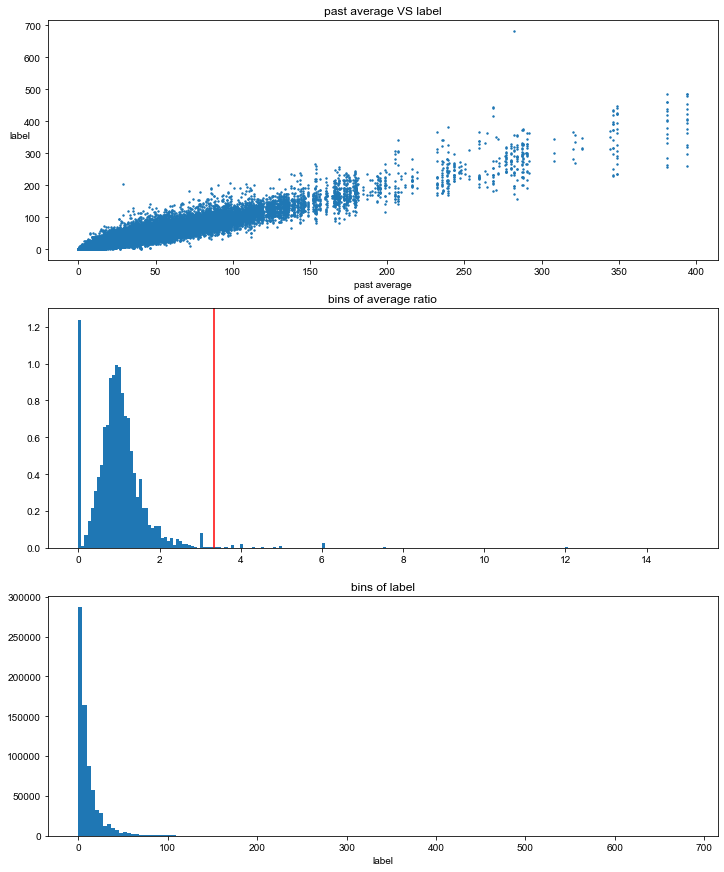

In [11]:
temp = t.copy(deep=True)
temp["avg_ratio"] = temp.label / temp.past_avg

fig, ax = plt.subplots(3, 1, figsize=(12, 15))
ax[0].scatter(t.past_avg, t.label, s=2)
ax[0].set_xlabel("past average")
ax[0].set_ylabel("label", rotation=0)
ax[0].set_title("past average VS label")

ax[1].hist(temp.avg_ratio, density=True, bins=200)
ax[1].axvline(temp.avg_ratio.quantile(0.99), c="red")
ax[1].set_title("bins of average ratio")


ax[2].hist(temp.label, bins=150)
ax[2].set_xlabel("label")
ax[2].set_title("bins of label")
plt.draw()

# xgb模型设计

## Huber loss模型

### 模型设计思路

        根据数据可以看出，数据在0值附近非常稠密，但是在非零值附近非常稀疏。
    
        
        又因为目标检测需求为mae与mape，且mae是绝对值，在0值附近不连续不可倒；因此需要使用自定义损失函数来在0值逼近mae，目前选用huober loss来在0值进行逼近。Huober loss的原理：https://blog.csdn.net/u013841196/article/details/89923475

### 模型implementation

In [62]:
def train_xgb_model(df, feat_col, model_name, label_col=["label"], test_size=0.2, random_state=1024, max_depth=1, verbose=10):
    train_set, val_set = train_test_split(df, test_size=test_size, random_state=random_state)

    print("********************** Data Split Finish **********************")
    print("********************** Init Model ... **********************")
    other_params = {
        'learning_rate': 0.1,
        'n_estimators': max_depth,
        'max_depth': 6,
        'min_child_weight': 9,
        'seed': 0,
        'subsample': 0.9,
        'colsample_bytree': 0.77,
        #'gamma': 7.6,
        #'reg_alpha': 0.1,
        #'reg_lambda': 1,
        'early_stopping_rounds': 5,
        'random_state': 0,
        'objective':huber_approx_obj
    }
    xgbregressor = xgb.XGBRegressor(**other_params)
    xgbregressor.fit(train_set[feat_col].astype('float').values, train_set[label_col].astype('float').values,
                     eval_set=[(val_set[feat_col].astype('float').values, val_set[label_col].astype('float').values)], eval_metric=custom_eval, verbose=20)

    print("********************** Start Training **********************")
    print("x.shape: ")
    print(train_set[feat_col].values.shape)
    print("y.shape: ")
    print(train_set[label_col].values.shape)
    print("********************** Training Finish **********************")
#     mape = xgb_mape(xgbregressor.predict(),dtest)
#     print(mape)
    model_save_file = "../saved model/"+ model_name +'.model'
    xgbregressor.save_model(model_save_file)
    print("保存模型到: ", model_save_file)
    
    return xgbregressor

In [13]:
def custom_eval(preds, dtrain):
    label = dtrain.get_label()
    mape = 0
    n_mape = 0
    mae = 0
    n_mae = 0
    for i in range(label.shape[0]):
        if (label[i] >= 10):
            mape += np.abs(preds[i] - label[i]) / label[i]
            n_mape += 1
        else:
            mae += np.abs(preds[i] - label[i])
            n_mae += 1

    return  [('myeval', mape / n_mape + mae / n_mae),('MAPE', mape / n_mape ),('MAE', mae / n_mae)]


def huber_approx_obj(dtrain, preds):
    labels = dtrain
    n = preds.shape[0]
    grad = np.empty(n)
    hess = 500 * np.ones(n)
    scale = 1.0
    flag = 0.1
    for i in range(n):
        diff = preds[i] - labels[i]
        if labels[i] >= 10:
            #scale = float(labels[i]) / 100
            #flag = 0
            scale = 1.0
        if diff > 0:
            grad[i] = 150/scale + 50 + 40 * diff  * flag
        elif diff < 0:
            grad[i] = -150/scale - 50 + 40 * diff * flag
        else:
            grad[i] = 0
        # if labels[i]>10:
        #     grad[i] = (-2 * labels[i]) + (2 * preds[i])
        #     hess[i] = 0*(labels[i] + preds[i]) + 2
    return grad, hess

def grad(dtrain, preds):
    labels = dtrain
    n = preds.shape[0]
    grad = np.empty(n)
    hess = 500 * np.ones(n)
    for i in range(n):
        diff = preds[i] - labels[i]
        if diff > 0:
            grad[i] = 200
        elif diff < 0:
            grad[i] = -200
        else:
            grad[i] = 0
    return grad, hess


### 模型训练

In [64]:
feature_col = [col for col in t.columns if col not in["Timestamp", "label"]]
past_avg = train_xgb_model(t, feature_col, "past_avg", max_depth=85, verbose=1)

********************** Data Split Finish **********************
********************** Init Model ... **********************
[19:03:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:20.33963	validation_0-myeval:4.08515	validation_0-MAPE:0.96900	validation_0-MAE:3.11615
[20]	validation_0-rmse:19.61674	validation_0-myeval:3.47127	validation_0-MAPE:0.91011	validation_0-MAE:2.56116
[40]	validation_0-rmse:18.92376	validation_0-myeval:2.99577	validation_0-MAPE:0.85237	validation_0-MAE:2.14340
[60]	validation_0-rmse:18.26102	validation_0-myeval:2.62716	validation_0-MAPE:0.79627	validat

In [65]:
t

,Timestamp,grid,idle_drive1,idle_drive2,idle_drive3,idle_drive4,idle_drive5,idle_drive6,idle_drive7,label,order_create1,order_create2,order_create3,order_create4,order_create5,order_create6,order_create7,respond_order1,respond_order2,respond_order3,respond_order4,respond_order5,respond_order6,respond_order7,unboard_order1,unboard_order2,unboard_order3,unboard_order4,unboard_order5,unboard_order6,unboard_order7,hr,weekday,past_avg
0,2018-08-15 00:10:00,18,6,5,3,1,15,17,16,1,0,0,1,4,2,2,3,0,0,1,4,2,2,3,0,0,0,0,0,0,1,0,2,0.866667
1,2018-08-15 00:20:00,18,6,6,5,3,1,15,17,4,1,0,0,1,4,2,2,1,0,0,1,4,2,2,0,0,0,0,0,0,0,0,2,0.866667
2,2018-08-15 00:30:00,18,3,6,6,5,3,1,15,1,4,1,0,0,1,4,2,4,1,0,0,1,4,2,1,0,0,0,0,0,0,0,2,0.866667
3,2018-08-15 00:40:00,18,1,3,6,6,5,3,1,2,1,4,1,0,0,1,4,1,4,1,0,0,1,4,0,1,0,0,0,0,0,0,2,0.866667
4,2018-08-15 00:50:00,18,3,1,3,6,6,5,3,0,2,1,4,1,0,0,1,2,1,4,1,0,0,1,0,0,1,0,0,0,0,0,2,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728995,2018-08-09 20:20:00,47,726,646,711,754,818,880,924,55,37,55,37,43,53,49,36,34,45,37,34,46,45,32,20,32,20,22,20,12,18,20,3,49.600000
728996,2018-08-09 20:30:00,47,605,726,646,711,754,818,880,48,55,37,55,37,43,53,49,51,34,45,37,34,46,45,22,20,32,20,22,20,12,20,3,49.600000
728997,2018-08-09 20:40:00,47,445,605,726,646,711,754,818,37,48,55,37,55,37,43,53,40,51,34,45,37,34,46,29,22,20,32,20,22,20,20,3,49.600000
728998,2018-08-09 20:50:00,47,465,445,605,726,646,711,754,39,37,48,55,37,55,37,43,37,40,51,34,45,37,34,17,29,22,20,32,20,22,20,3,49.600000


### 模型表现

    模型在飞驰5期中获得了mae第一名的成绩，但是mape非常低。

    我认为因为label在0值附近稀疏，Huber loss让预测值偏大，所以mae下降，mape上升。

### random search

In [47]:
from sklearn.model_selection import RandomizedSearchCV

def train_xgb_model_random_search(df, feat_col, model_name, label_col=["label"], test_size=0.2, random_state=1024, max_depth=1, verbose=10):
    train_set, val_set = train_test_split(df, test_size=test_size, random_state=random_state)

    print("********************** Data Split Finish **********************")
    print("********************** Init Model ... **********************")
    param_dist = {
        'n_estimators':range(80,200,4),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1),
        }
    other_params = {
        'seed': 0,
        'gamma': 7.6,
        'reg_alpha': 0.1,
        'reg_lambda': 1,
        'early_stopping_rounds': 5,
        'random_state': random_state,
        'objective':huber_approx_obj,
        'verbose' : verbose
    }
    xgbregressor = xgb.XGBRegressor(**other_params)
    grid = RandomizedSearchCV(xgbregressor,param_dist,n_iter=30,n_jobs = -1)

    grid.fit(train_set[feat_col].astype('float').values, train_set[label_col].astype('float').values,
                     eval_set=[(val_set[feat_col].astype('float').values, val_set[label_col].astype('float').values)], eval_metric=custom_eval, verbose=True)

    print("********************** Start Training **********************")
#     print("x.shape: ")
#     print(train_set[feat_col].values.shape)
#     print("y.shape: ")
#     print(train_set[label_col].values.shape)
    print("********************** Training Finish **********************")
#     mape = xgb_mape(xgbregressor.predict(),dtest)
#     print(mape)
#     model_save_file = "../saved model/"+ model_name +'.model'
#     xgbregressor.save_model(model_save_file)
#     print("保存模型到: ", model_save_file)
    
    return grid

In [48]:
feature_col = [col for col in t.columns if col not in["Timestamp", "label"]]
past_avg = train_xgb_model_random_search(t, feature_col, "past_avg_search", max_depth=85)

********************** Data Split Finish **********************
********************** Init Model ... **********************


/Users/didi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[14:22:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:19.75470	validation_0-myeval:3.56362	validation_0-MAPE:0.92162	validation_0-MAE:2.64200
[1]	validation_0-rmse:19.15580	validation_0-myeval:3.16395	validation_0-MAPE:0.87218	validation_0-MAE:2.29177
[2]	validation_0-rmse:18.58939	validation_0-myeval:2.81437	validation_0-MAPE:0.82435	validation_0-MAE:1.99002
[3]	validation_0-rmse:18.03358	validation_0-myeval:2.51208	validation_0-MAPE:0.77678	validation_0-MAE:1.73531
[4]	validation_0-rmse:17.49832	validation_0-myeval:2.29074	validation_0-MAPE:0.73059	validation_0-MAE

[71]	validation_0-rmse:5.04592	validation_0-myeval:1.74475	validation_0-MAPE:0.21642	validation_0-MAE:1.52833
[72]	validation_0-rmse:5.01684	validation_0-myeval:1.74511	validation_0-MAPE:0.21638	validation_0-MAE:1.52873
[73]	validation_0-rmse:4.98935	validation_0-myeval:1.74445	validation_0-MAPE:0.21629	validation_0-MAE:1.52816
[74]	validation_0-rmse:4.96473	validation_0-myeval:1.74501	validation_0-MAPE:0.21623	validation_0-MAE:1.52878
[75]	validation_0-rmse:4.94058	validation_0-myeval:1.74457	validation_0-MAPE:0.21617	validation_0-MAE:1.52840
[76]	validation_0-rmse:4.91770	validation_0-myeval:1.74545	validation_0-MAPE:0.21610	validation_0-MAE:1.52936
[77]	validation_0-rmse:4.89589	validation_0-myeval:1.74473	validation_0-MAPE:0.21602	validation_0-MAE:1.52871
[78]	validation_0-rmse:4.87660	validation_0-myeval:1.74432	validation_0-MAPE:0.21600	validation_0-MAE:1.52833
[79]	validation_0-rmse:4.85745	validation_0-myeval:1.74420	validation_0-MAPE:0.21600	validation_0-MAE:1.52820
[80]	valid

[146]	validation_0-rmse:4.52778	validation_0-myeval:1.74683	validation_0-MAPE:0.21535	validation_0-MAE:1.53147
[147]	validation_0-rmse:4.52754	validation_0-myeval:1.74671	validation_0-MAPE:0.21535	validation_0-MAE:1.53137
[148]	validation_0-rmse:4.52667	validation_0-myeval:1.74679	validation_0-MAPE:0.21531	validation_0-MAE:1.53148
[149]	validation_0-rmse:4.52678	validation_0-myeval:1.74680	validation_0-MAPE:0.21529	validation_0-MAE:1.53151
[150]	validation_0-rmse:4.52525	validation_0-myeval:1.74687	validation_0-MAPE:0.21527	validation_0-MAE:1.53160
[151]	validation_0-rmse:4.52508	validation_0-myeval:1.74702	validation_0-MAPE:0.21526	validation_0-MAE:1.53176
[152]	validation_0-rmse:4.52514	validation_0-myeval:1.74658	validation_0-MAPE:0.21531	validation_0-MAE:1.53127
[153]	validation_0-rmse:4.52488	validation_0-myeval:1.74679	validation_0-MAPE:0.21531	validation_0-MAE:1.53147
[154]	validation_0-rmse:4.52460	validation_0-myeval:1.74698	validation_0-MAPE:0.21531	validation_0-MAE:1.53167
[

In [49]:
past_avg.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.82, early_stopping_rounds=5,
             gamma=7.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=1.6857894736842105,
             max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=164, n_jobs=8,
             num_parallel_tree=1,
             objective=<function huber_approx_obj at 0x7f82629973a0>,
             random_state=1024, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
             seed=0, subsample=0.8473684210526315, tree_method='exact',
             validate_parameters=1, verbose=10, verbosity=None)

#### 保存random search结果

In [53]:
# with open("../saved model/past_avg_random_search1.pkl", 'wb') as f:
#     pickle.dump(past_avg, f)
    
with open("../saved model/past_avg_random_search1.pkl", 'rb') as f:
    ttt = pickle.load(f)
ttt.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.82, early_stopping_rounds=5,
             gamma=7.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=1.6857894736842105,
             max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=164, n_jobs=8,
             num_parallel_tree=1,
             objective=<function huber_approx_obj at 0x7f82629973a0>,
             random_state=1024, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
             seed=0, subsample=0.8473684210526315, tree_method='exact',
             validate_parameters=1, verbose=10, verbosity=None)

# 预测环节

## 读出test1数据

In [76]:
dfs_test = []
for file in os.listdir(TEST1_PATH):
    if len(file) >= 4 and file[-4:] == ".csv":
        dfs_test.append(pd.read_csv(os.path.join(TEST1_PATH, file), sep=",", header=None))
df_test = pd.concat(dfs_test)
df_test.reset_index(drop=True, inplace=True)
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2018-08-23 02:00:00,OL13F1i5014j2513,1 0 1 1,3 0 2 2,0 0 0 0,0 0 1 1,2 0 1 1,0 0 1 1,0 0 0 0,0 0 2 2,0 0 1 1,0 0 0 0,0 0 0 0,0 0 1 1
1,2018-08-23 02:00:00,OL13F1i5055j2490,0 0 1 1,4 1 1 1,3 0 0 0,0 0 0 0,1 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,1 0 0 0,0 0 1 1,0 0 0 0
2,2018-08-23 02:00:00,OL13F1i5037j2536,2 0 0 0,2 0 0 0,1 0 1 1,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,1 0 0 0
3,2018-08-23 02:00:00,OL13F1i5070j2494,1 0 2 2,3 0 5 5,5 0 0 0,5 0 4 3,3 0 1 1,0 0 0 0,0 0 0 0,0 0 0 0,0 0 0 0,0 0 1 1,0 0 1 1,0 0 0 0
4,2018-08-23 02:00:00,OL13F1i5072j2499,3 0 0 1,8 0 1 1,4 0 0 0,5 0 1 1,10 1 1 1,1 0 0 0,6 0 0 0,8 0 0 0,6 0 0 0,6 0 0 0,2 0 1 1,3 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,2018-08-24 22:00:00,OL13F1i5046j2513,266 51 113 106,276 74 100 91,275 105 141 128,347 81 120 121,382 113 136 105,480 118 138 108,485 327 315 272,465 316 217 180,462 285 172 135,375 347 197 145,375 447 160 108,287 564 207 126
32396,2018-08-24 22:00:00,OL13F1i5055j2527,287 8 70 70,395 13 65 65,600 4 54 53,845 8 46 45,1168 2 41 41,1860 58 32 30,2176 810 592 445,1855 710 222 213,1675 369 180 176,1418 158 162 143,1348 228 191 167,1096 138 148 158
32397,2018-08-24 22:00:00,OL13F1i5052j2513,352 16 74 73,300 8 88 86,220 22 96 93,195 30 83 75,161 27 98 96,100 101 141 113,131 71 156 143,60 151 148 121,68 241 158 111,12 392 200 121,41 582 205 123,53 803 256 116
32398,2018-08-24 22:00:00,OL13F1i5033j2522,163 40 81 73,121 105 93 65,140 45 66 55,148 70 74 60,125 43 74 60,126 86 75 55,123 217 111 64,90 96 76 66,75 138 76 45,59 165 101 59,70 369 126 40,63 545 138 48
